In [1]:
import pandas as pd
import numpy as np
from faker import Faker
import uuid
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Initialize Faker
fake = Faker()

# Constants
TOTAL_ROWS = 1000
NUM_FRAUD_ROWS = 100  # Total fraudulent rows
NUM_FRAUD_IDS = 50     # Number of unique fraudulent IDs
FRAUD_DUPLICATES = 2   # Number of duplicates per fraud ID (2 for pairing)

# Event and ticket category lists
EVENTS = [
    "Concert A",
    "Concert B",
    "Sports Event A",
    "Sports Event B",
    "Festival A",
    "Festival B",
    "Theater A",
    "Theater B"
]
TICKET_CATEGORIES = ["VIP", "General", "Balcony", "Standing", "Premium", "Economy"]

def generate_wallet_address():
    """Generates a fake Ethereum-like wallet address."""
    return '0x' + ''.join(np.random.choice(list('0123456789abcdef'), size=40))

def generate_event_timestamp():
    """Generates a random event timestamp between Jan 1, 2025 and Dec 31, 2025."""
    start_date = datetime(2025, 1, 1)
    end_date = datetime(2025, 12, 31, 23, 59, 59)
    return fake.date_time_between(start_date=start_date, end_date=end_date)

def generate_transaction_timestamp(event_time):
    """Generates a transaction timestamp before the event timestamp."""
    # Ensure the transaction is at least 1 hour before the event and at most 30 days before
    min_delta = timedelta(hours=1)
    max_delta = timedelta(days=30)
    delta_seconds = np.random.randint(int(min_delta.total_seconds()), int(max_delta.total_seconds()))
    delta = timedelta(seconds=delta_seconds)
    transaction_time = event_time - delta
    return transaction_time

# -- Step 1: Generate a Single Organizer Wallet Address --
organizer_wallet = generate_wallet_address()

# Initialize data dictionary
data = {
    "ID": [],
    "event_timestamp": [],
    "transaction_timestamp": [],
    "event": [],
    "ticket_price": [],
    "ticket_category": [],
    "buyer_wallet_address": [],
    "seller_wallet_address": [],
    "organizer_wallet_address": []
}

# -- Step 2: Generate Fraudulent Transactions --
for _ in range(NUM_FRAUD_IDS):
    # Generate a unique fraudulent ID
    fraud_id = str(uuid.uuid4())

    # Select a random event
    event = np.random.choice(EVENTS)

    # Generate a single event timestamp
    event_time = generate_event_timestamp()

    # Generate a base transaction timestamp
    base_transaction_time = generate_transaction_timestamp(event_time)

    for _ in range(FRAUD_DUPLICATES):
        # Append the same ID for fraud
        data["ID"].append(fraud_id)

        # Event details
        data["event"].append(event)
        data["event_timestamp"].append(event_time)

        # For fraudulent transactions, introduce slight variations in transaction timestamp
        # To simulate duplicate or near-duplicate timestamps, add small random seconds
        variation_seconds = np.random.randint(0, 60)  # Up to 1 minute difference
        transaction_time = base_transaction_time + timedelta(seconds=variation_seconds)
        data["transaction_timestamp"].append(transaction_time)

        # Ticket price (can vary slightly)
        ticket_price = round(np.random.uniform(50, 500), 2)
        data["ticket_price"].append(ticket_price)

        # Ticket category
        ticket_category = np.random.choice(TICKET_CATEGORIES)
        data["ticket_category"].append(ticket_category)

        # Different buyer wallets for each fraud transaction
        buyer_wallet = generate_wallet_address()
        data["buyer_wallet_address"].append(buyer_wallet)

        # Seller wallet: Must differ from organizer_wallet
        while True:
            seller_wallet = generate_wallet_address()
            if seller_wallet != organizer_wallet:
                break
        data["seller_wallet_address"].append(seller_wallet)

        # Organizer wallet: Same for all rows
        data["organizer_wallet_address"].append(organizer_wallet)

# -- Step 3: Generate Legitimate Transactions --
NUM_LEGIT_ROWS = TOTAL_ROWS - NUM_FRAUD_ROWS  # 900

for _ in range(NUM_LEGIT_ROWS):
    # Generate unique ID
    legit_id = str(uuid.uuid4())
    data["ID"].append(legit_id)

    # Select a random event
    event = np.random.choice(EVENTS)
    data["event"].append(event)

    # Generate event timestamp
    event_time = generate_event_timestamp()
    data["event_timestamp"].append(event_time)

    # Generate transaction timestamp
    transaction_time = generate_transaction_timestamp(event_time)
    data["transaction_timestamp"].append(transaction_time)

    # Generate ticket price (e.g., between 50 to 500 units)
    ticket_price = round(np.random.uniform(50, 500), 2)
    data["ticket_price"].append(ticket_price)

    # Select a random ticket category
    ticket_category = np.random.choice(TICKET_CATEGORIES)
    data["ticket_category"].append(ticket_category)

    # Generate buyer wallet
    buyer_wallet = generate_wallet_address()
    data["buyer_wallet_address"].append(buyer_wallet)

    # Seller wallet: 
    # For legitimate transactions, assume seller is the organizer
    seller_wallet = organizer_wallet  # Seller is the organizer
    data["seller_wallet_address"].append(seller_wallet)

    # Organizer wallet: Same for all rows
    data["organizer_wallet_address"].append(organizer_wallet)

# -- Step 4: Create DataFrame --
df = pd.DataFrame(data)

# -- Step 5: Shuffle the DataFrame --
# To mix fraudulent and legitimate transactions
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

# -- Step 6: Sort by transaction timestamp --
df = df.sort_values(by="transaction_timestamp").reset_index(drop=True)

# -- Step 7: Save to CSV --
df.to_csv("fake_blockchain_transactions_with_fraud.csv", index=False)



In [2]:
# -- Step 7: Save to JSON -- # <- Modified Section
df.to_json(
    "fake_blockchain_transactions_with_fraud.json",
    orient="records",
    lines=True,          # Writes each record on a separate line
    date_format='iso'    # Ensures datetime is in ISO format
)

In [3]:
df.head(5)

,ID,event_timestamp,transaction_timestamp,event,ticket_price,ticket_category,buyer_wallet_address,seller_wallet_address,organizer_wallet_address
0,4bad9fa4-89bd-4f64-8411-137196c8078b,2025-01-03 13:43:17,2024-12-05 22:59:54,Sports Event A,439.97,Standing,0xa1a97202f33915bb5df6d1c7e86de2ad26f453a8,0x496a07d8d19089c60cedaea97f44f48304eedbb5,0x496a07d8d19089c60cedaea97f44f48304eedbb5
1,65ccf914-9f26-4c8f-9c00-8fb489154b0c,2025-01-06 09:49:41,2024-12-07 15:27:36,Sports Event B,318.17,Standing,0x06510911b7f4970da322665fa80e48442798d404,0x496a07d8d19089c60cedaea97f44f48304eedbb5,0x496a07d8d19089c60cedaea97f44f48304eedbb5
2,dba33c21-f7ea-45bb-bf37-6cd437f355c2,2025-01-02 07:21:13,2024-12-09 05:13:55,Concert B,140.17,Balcony,0x01e558ab34ca01aaa1421f7c6a34d492c6b87551,0x496a07d8d19089c60cedaea97f44f48304eedbb5,0x496a07d8d19089c60cedaea97f44f48304eedbb5
3,692cf9dc-eea9-4fa7-bc7f-8401998844de,2025-01-06 11:14:34,2024-12-10 03:27:43,Festival B,414.14,Premium,0xf67fd19101767810401ea5a03666ddaf23186ac0,0x496a07d8d19089c60cedaea97f44f48304eedbb5,0x496a07d8d19089c60cedaea97f44f48304eedbb5
4,34013d79-1715-4026-afbc-8a67cb633911,2025-01-06 13:16:33,2024-12-10 09:31:48,Concert B,405.23,General,0x796e2f85d6bb149c426137cb416f275d14907566,0x496a07d8d19089c60cedaea97f44f48304eedbb5,0x496a07d8d19089c60cedaea97f44f48304eedbb5


In [4]:
# condition to identify fraud event is same ID, timestamp arounf 1 minute, diffeent wallet buyers and wallet seller different from organizer 

In [5]:
# --------------------------------------------
# Identify Duplicate IDs
# --------------------------------------------

# Identify IDs that appear more than once
duplicate_ids = df['ID'].value_counts()[df['ID'].value_counts() > 1].index.tolist()

print(f"Total duplicate IDs (potential fraud cases): {len(duplicate_ids)}")

# --------------------------------------------
# Analyze Transactions with Duplicate IDs
# --------------------------------------------

# Define the time window for similar timestamps (e.g., 1 minute)
TIME_WINDOW = timedelta(minutes=1)

def is_fraudulent(group):
    """
    Determines if a group of transactions with the same ID is fraudulent based on:
    1. Transactions are within TIME_WINDOW of each other.
    2. All buyer_wallet_addresses are unique.
    3. seller_wallet_address differs from organizer_wallet_address.
    """
    # Check if all transaction timestamps are within TIME_WINDOW
    min_time = group['transaction_timestamp'].min()
    max_time = group['transaction_timestamp'].max()
    time_diff = max_time - min_time
    if time_diff > TIME_WINDOW:
        return False

    # Check if all buyer_wallet_addresses are unique
    if group['buyer_wallet_address'].nunique() != len(group):
        return False

    # Check if seller_wallet_address differs from organizer_wallet_address for all transactions
    if not all(group['seller_wallet_address'] != group['organizer_wallet_address']):
        return False

    return True

# --------------------------------------------
# Flagging Fraudulent Transactions
# --------------------------------------------

# Initialize a column to flag fraudulent transactions
df['is_fraud'] = False

# Group the DataFrame by ID
grouped = df.groupby('ID')

# Apply the fraud detection function
for fraud_id in duplicate_ids:
    group = grouped.get_group(fraud_id)
    if is_fraudulent(group):
        df.loc[df['ID'] == fraud_id, 'is_fraud'] = True

# Count the number of frauds detected
frauds_detected = df[df['is_fraud']].shape[0]
print(f"Total fraudulent transactions detected: {frauds_detected}")

# --------------------------------------------
# Summary and Output
# --------------------------------------------

# Summary
total_transactions = df.shape[0]
legit_transactions = total_transactions - frauds_detected

print("\n--- Fraud Detection Summary ---")
print(f"Total Transactions: {total_transactions}")
print(f"Legitimate Transactions: {legit_transactions}")
print(f"Fraudulent Transactions: {frauds_detected}")

# Display sample fraudulent transactions
print("\nSample Fraudulent Transactions:")
df[df['is_fraud']].head(10)


Total duplicate IDs (potential fraud cases): 50
Total fraudulent transactions detected: 100

--- Fraud Detection Summary ---
Total Transactions: 1000
Legitimate Transactions: 900
Fraudulent Transactions: 100

Sample Fraudulent Transactions:


,ID,event_timestamp,transaction_timestamp,event,ticket_price,ticket_category,buyer_wallet_address,seller_wallet_address,organizer_wallet_address,is_fraud
56,6c38d037-38d5-457a-b074-ea66d89740e9,2025-01-13 10:22:31,2025-01-09 10:00:18,Festival A,200.54,Premium,0x4e126eda7f7cd979d361ca6cdf0fdbaf2c37f7be,0x0643357cdd2f507a2ccffa63838a2dae9d06a776,0x496a07d8d19089c60cedaea97f44f48304eedbb5,True
57,6c38d037-38d5-457a-b074-ea66d89740e9,2025-01-13 10:22:31,2025-01-09 10:00:23,Festival A,446.84,General,0xfb52f3017021dc1dcc18da2dc89e0b7b1ebd41ac,0xaa51ed6d90c0088d340e2277269821038160a024,0x496a07d8d19089c60cedaea97f44f48304eedbb5,True
65,46770643-2741-4d58-aedf-51ba72e0821f,2025-01-24 01:36:02,2025-01-11 19:41:21,Concert A,327.28,General,0x1e05c51d319cfb7e45b8ff128c52143f1fbd4db6,0x14583ad93a60c51e2ef06cf4b02b935c9d151df4,0x496a07d8d19089c60cedaea97f44f48304eedbb5,True
66,46770643-2741-4d58-aedf-51ba72e0821f,2025-01-24 01:36:02,2025-01-11 19:41:28,Concert A,142.35,Standing,0xa4bd310f85eebf07b2ccd34a671da0adff5659eb,0x9be5a2e874b1f35fe2265c9f8359d17e0d47c702,0x496a07d8d19089c60cedaea97f44f48304eedbb5,True
77,6d26987b-ffcc-475c-b652-f165c4dafd1b,2025-01-17 14:56:41,2025-01-16 03:38:49,Sports Event B,335.16,Economy,0x6d5eb352c8b395e352a31416be9e4f5db50821b3,0xc6f6e799d83cb31ca1ac0f2e87577213a9604f40,0x496a07d8d19089c60cedaea97f44f48304eedbb5,True
78,6d26987b-ffcc-475c-b652-f165c4dafd1b,2025-01-17 14:56:41,2025-01-16 03:39:24,Sports Event B,98.36,Economy,0x85ae1f340760760ba0ab02d3e14670e9b429f571,0x56835f8de3692ef3e624b2b4c9a16424dcb8e164,0x496a07d8d19089c60cedaea97f44f48304eedbb5,True
133,10fbcf33-94cc-4d56-beb8-8a37b6090bdc,2025-03-03 09:24:51,2025-02-06 08:07:04,Festival B,308.77,VIP,0x88561e240c5123dc2b067ddf4f21e969b292577c,0xec8d27b68da442e375043f28a731c907f9ba88d9,0x496a07d8d19089c60cedaea97f44f48304eedbb5,True
134,10fbcf33-94cc-4d56-beb8-8a37b6090bdc,2025-03-03 09:24:51,2025-02-06 08:07:12,Festival B,293.31,Standing,0x9e01736e8cbfee72dda243f263d1b8a729292156,0x61f6a6a35e39f89d0b45baa4b912359b6e949c2f,0x496a07d8d19089c60cedaea97f44f48304eedbb5,True
140,21291461-acfd-406c-afc0-01cbfd69d657,2025-03-08 23:51:47,2025-02-07 21:49:47,Concert B,256.52,Economy,0xbb83f12458ebe528f18e0daf28ed2cd682ca1284,0x589e0a71a21dbab99e7f6ae67ee2c8a6ab2982fd,0x496a07d8d19089c60cedaea97f44f48304eedbb5,True
141,21291461-acfd-406c-afc0-01cbfd69d657,2025-03-08 23:51:47,2025-02-07 21:49:52,Concert B,167.35,Standing,0xb096fd4a4eb0984b6538e34c5b503cdaf2b29e9e,0x9cd2f7b9bd465c12098b7bcb3398f678ee9f36a5,0x496a07d8d19089c60cedaea97f44f48304eedbb5,True


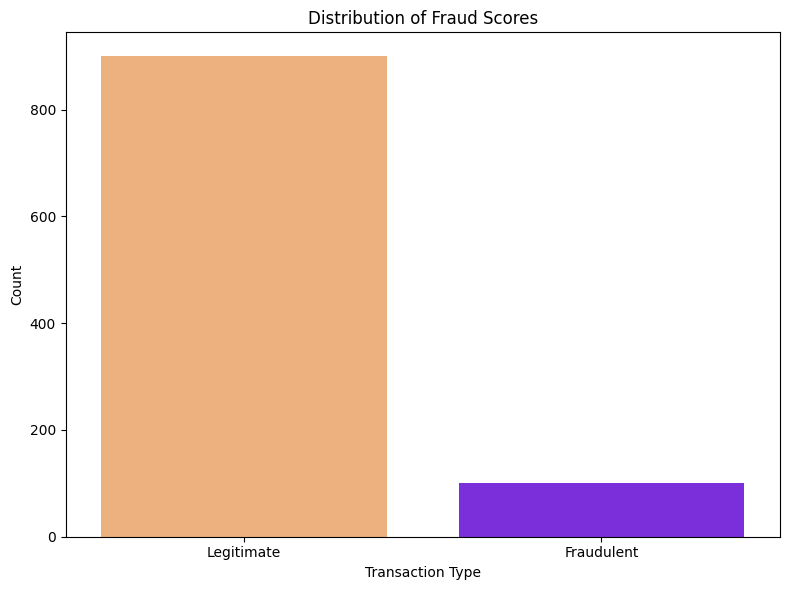

In [10]:
# Define custom colors using string keys
FRAUD_COLOR = '#7813f6'   # Rich Purple
LEGIT_COLOR = '#ffaf6e'   # Warm Peachy Orange

# Convert boolean to string in 'is_fraud' for consistent palette mapping
df['is_fraud_str'] = df['is_fraud'].astype(str)

# Define the palette with string keys
palette = {
    'True': FRAUD_COLOR,
    'False': LEGIT_COLOR
}

plt.figure(figsize=(8, 6))
sns.countplot(
    x='is_fraud_str',
    data=df,
    palette=palette
)
plt.title('Distribution of Fraud Scores')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Legitimate', 'Fraudulent']) 
plt.savefig('fraud_distribution_countplot.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

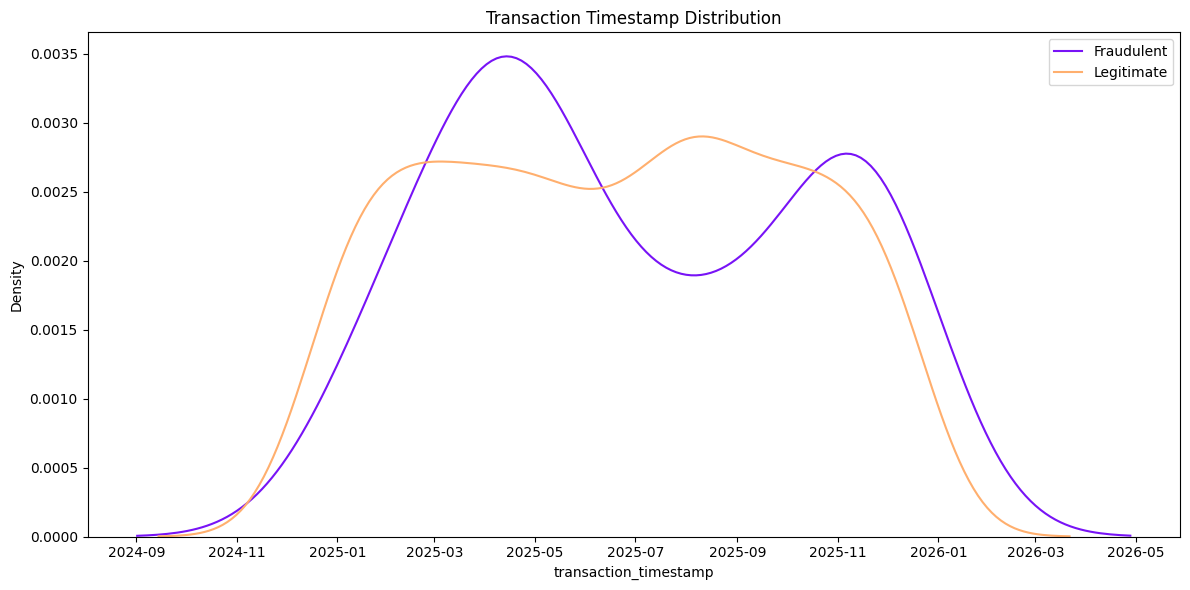

In [13]:
# Example: Timestamps of fraudulent vs legitimate transactions
plt.figure(figsize=(12,6))
sns.kdeplot(df[df['is_fraud']]['transaction_timestamp'], label='Fraudulent', color=FRAUD_COLOR)
sns.kdeplot(df[~df['is_fraud']]['transaction_timestamp'], label='Legitimate',color=LEGIT_COLOR)
plt.title('Transaction Timestamp Distribution')
plt.legend()
plt.tight_layout()
plt.savefig('transaction_timestamp_distribution.png', dpi=300, bbox_inches='tight')
plt.show()